In [5]:
# Import required libraries
import d3dshot
import tensorflow as tf
import cv2
from PIL import Image, ImageGrab, ImageEnhance
import numpy as np
import win32gui as w
import win32api, win32con
from ctypes import windll
from time import sleep
import winsound
import math
import matplotlib.pyplot as plt
import imutils
import pandas as pd
import joblib
import pytesseract
import re
from pynput.keyboard import Key, Controller

In [6]:
# Declare global variables

# Fixed image co-ordinates for OpenCV operations. (Calculated for my 1080p display - Your settings may vary)
I_WIDTH, I_HEIGHT = 224, 224
ORG_Y, ORG_X = int(I_HEIGHT*(2/3)), int(I_WIDTH/2)
OFFSET_ANGLE = 90
SPEEDBOX_Y, SPEEDBOX_YH, SPEEDBOX_X, SPEEDBOX_XH = 527, 553, 615, 685
ALTIBOX_Y, ALTIBOX_YH, ALTIBOX_X, ALTIBOX_XH = SPEEDBOX_Y, SPEEDBOX_YH, 1230, 1320

TRAIN_DF_COL_NAMES = ['imgPath','angle','distance','speed','altitude','key_a','key_d','key_1','key_3','key_q','key_e','key_w','key_s']
CSV_DATASET_PATH = 'dataset//train.csv'
keyList = ['\b', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', ' ', '1', '2', '3', '4', '5', '6', '7', '8', '9', ',', '.']

redMin = np.array([0,0,0])
redMax = np.array([30,255,255])
whiteMin = np.array([0,0,90])
whiteMax = np.array([180,10,100])
greenMin = np.array([40,20,20])
greenMax = np.array([70,255,255])
sharpeningKernel = np.array([[-1,-1,-1], [-1,9,-1], [-1,-1,-1]])

keyboard = Controller()
KEY_PRESS_TIME = 0.01

user32 = windll.user32
user32.SetProcessDPIAware()

1

In [7]:
# Return keypresses asynchronously
def checkKeys():
    keys = []
    for key in keyList:
        if win32api.GetAsyncKeyState(ord(key)):
            keys.append(key)
    return keys

In [8]:
# Grab game screenshot
def getScreenshot(convertToNumpy=True):
    while True:
        try:
            win32api.keybd_event(win32con.VK_SNAPSHOT,1)
            i = ImageGrab.grabclipboard()
            if convertToNumpy:
                i = np.array(i,dtype='uint8')
                i = cv2.cvtColor(i, cv2.COLOR_BGR2RGB)
            return i
        except TypeError:
            return np.zeros([1920,1080],dtype='uint8')

In [9]:
# Main Call
if __name__ == "__main__":
    pass

In [10]:
# Return angle in degrees between plane and target
def getTargetAngleAndDistance(cx, cy):
    angles = []
    distances = []
    for i in range(0,len(cx)):
        angle = math.atan2(ORG_Y-cy[i], ORG_X-cx[i])
        angle = math.degrees(angle) - OFFSET_ANGLE
        angles.append(round(angle,2))
        distances.append(round(math.sqrt((ORG_Y-cy[i])**2 + (ORG_X-cx[i])**2),2))
    return angles, distances

In [11]:
# Converts RGB image to binary image for contour detection
def rgbToBinary(img):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    blurred = cv2.GaussianBlur(gray, (3, 3), 0)
    thresh = cv2.threshold(blurred, 60, 255, cv2.THRESH_BINARY)[1]
    thresh = cv2.dilate(thresh, np.ones((2,2), np.uint8), iterations=1)
    return thresh

In [12]:
# Return contours from binary image
def getContours(bImg):
    cnts = cv2.findContours(bImg.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    return cnts

In [13]:
# Returns Center pixel of each contour for arctan2 calculations
def getContourCenter(cnts):
    cX = []
    cY = []
    for c in cnts:
        M = cv2.moments(c)
        cX.append(int(M["m10"] / M["m00"]))
        cY.append(int(M["m01"] / M["m00"]))
    return cX, cY

In [14]:
# Convert RGB image to HSV & return required colour by masking everything else.
def getRedColor(rgbImg, BGRinput=False):
    hsvImg = None
    if BGRinput:
        hsvImg = cv2.cvtColor(rgbImg, cv2.COLOR_BGR2HSV)
    else:
        hsvImg = cv2.cvtColor(rgbImg, cv2.COLOR_RGB2HSV)
    mask = cv2.inRange(hsvImg, redMin, redMax)
    mask2 = cv2.inRange(hsvImg, whiteMin, whiteMax)
    mask = cv2.bitwise_or(mask, mask2)
    masked = cv2.bitwise_and(rgbImg, rgbImg, mask=mask)
    return masked

def getGreenColor(rgbImg, BGRinput=False):
    hsvImg = None
    if BGRinput:
        hsvImg = cv2.cvtColor(rgbImg, cv2.COLOR_BGR2HSV)
    else:
        hsvImg = cv2.cvtColor(rgbImg, cv2.COLOR_RGB2HSV)
    mask = cv2.inRange(hsvImg, greenMin, greenMax)
    masked = cv2.bitwise_and(rgbImg, rgbImg, mask=mask)
    return masked

In [15]:
# Make beeps for status alerts
def makeBeep(pattern):
    if pattern == 'on':
        winsound.Beep(2500,500)
        winsound.Beep(3500,500)
        winsound.Beep(4500,500)
    elif pattern == 'off':
        winsound.Beep(4500,500)
        winsound.Beep(3500,500)
        winsound.Beep(2500,500)  

In [16]:
# Returns an empty pandas dataframe for dataset storage
def createDataFrame():
    return pd.DataFrame(columns=TRAIN_DF_COL_NAMES)

In [17]:
# Returns the clean the OCR String
def processOCR(s):
    s = s.replace("%","0").replace("I","1").replace("a","2").replace("S","5").replace("s","5")
    s = re.sub('[^0-9]+', '', s)
    return s

In [18]:
# Returns speed value from HUD using OCR
def getSpeed(i):
    global speedQue
    try:
        i = i[SPEEDBOX_Y:SPEEDBOX_YH, SPEEDBOX_X:SPEEDBOX_XH]
        i = cv2.cvtColor(i, cv2.COLOR_RGB2GRAY)
        i = cv2.GaussianBlur(i,(3,3),cv2.BORDER_DEFAULT)
        i = cv2.filter2D(i,-1,sharpeningKernel)
        speed = pytesseract.image_to_string(i,lang='eng')
        speed = processOCR(speed)
        return speed
    except:
        return "0"

# Returns altitude value from HUD using OCR
def getAltitude(i):
    global altiQue
    try:
        i = i[ALTIBOX_Y:ALTIBOX_YH, ALTIBOX_X:ALTIBOX_XH]
        i = cv2.cvtColor(i, cv2.COLOR_RGB2GRAY)
        i = cv2.GaussianBlur(i,(3,3),cv2.BORDER_DEFAULT)
        i = cv2.filter2D(i,-1,sharpeningKernel)
        alt = pytesseract.image_to_string(i,lang='eng')
        alt = processOCR(alt)
        return alt
    except:
        return "0"

In [19]:
# Get map image from game for dataset generation when the user takes control actions
def getMapData():
    cnt = 0
    controlFlag = False
    df = createDataFrame()
    while True:
        try:
            k = checkKeys()
            if 'k' in k:
                winsound.Beep(1500,700)
                break
            if 'Q' in k and 'E' in k:
                controlFlag = not controlFlag
                if controlFlag:
                    makeBeep('on')
                else:
                    makeBeep('off')
                    df.to_csv(CSV_DATASET_PATH)
                    break
            if len(k) > 0 and controlFlag:
                SAVE_PATH = None
                PROCESS_FLAG = False
                KEY_Q = 0
                KEY_E = 0
                KEY_A = 0
                KEY_D = 0
                KEY_W = 0
                KEY_S = 0
                KEY_1 = 0
                KEY_3 = 0
                if 'Q' in k:
                    SAVE_PATH = 'dataset/Q/Q_'+str(cnt)+'.jpg'
                    PROCESS_FLAG = True
                    KEY_Q = 1
                if 'E' in k:
                    SAVE_PATH = 'dataset/E/E_'+str(cnt)+'.jpg'
                    PROCESS_FLAG = True
                    KEY_E = 1
                if 'A' in k:
                    SAVE_PATH = 'dataset/A/A_'+str(cnt)+'.jpg'
                    PROCESS_FLAG = True
                    KEY_A = 1
                if 'D' in k:
                    SAVE_PATH = 'dataset/D/D'+str(cnt)+'.jpg'
                    PROCESS_FLAG = True
                    KEY_D = 1
                if 'W' in k:
                    SAVE_PATH = 'dataset/W/W'+str(cnt)+'.jpg'
                    PROCESS_FLAG = True
                    KEY_W = 1
                if 'S' in k:
                    SAVE_PATH = 'dataset/S/S'+str(cnt)+'.jpg'
                    PROCESS_FLAG = True
                    KEY_S = 1
                if '1' in k:
                    SAVE_PATH = 'dataset/1/1'+str(cnt)+'.jpg'
                    PROCESS_FLAG = True
                    KEY_1 = 1
                if '3' in k:
                    SAVE_PATH = 'dataset/3/3'+str(cnt)+'.jpg'
                    PROCESS_FLAG = True
                    KEY_3 = 1
                if PROCESS_FLAG:
                    screenshot = getScreenshot(convertToNumpy=True)
                    i = screenshot[723:1026,98:401]
                    i = cv2.resize(i, (I_WIDTH, I_HEIGHT))
                    i = Image.fromarray(i)
                    ce, be, cole = ImageEnhance.Contrast(i), ImageEnhance.Brightness(i), ImageEnhance.Color(i)
                    i = be.enhance(0.2)
                    i = ce.enhance(0.5)
                    i = cole.enhance(3.0)
                    i = np.asarray(i)
                    i = getRedColor(i,BGRinput=True)
                    cv2.imwrite(SAVE_PATH,i)
                    i = rgbToBinary(i)
                    cnts = getContours(i)
                    cx, cy = getContourCenter(cnts)
                    angles, dist = getTargetAngleAndDistance(cx, cy)
                    speed = getSpeed(screenshot)
                    altitude = getAltitude(screenshot)
                    for i in range(0,len(angles)):
                        df = pd.concat([pd.DataFrame([[SAVE_PATH, angles[i], dist[i], speed, altitude, KEY_A, KEY_D, KEY_1, KEY_3, KEY_Q, KEY_3, KEY_W, KEY_S]],columns=TRAIN_DF_COL_NAMES),df])
                    cnt +=1
                sleep(0.01)
        except ZeroDivisionError:
            pass
        except KeyboardInterrupt:
            df.to_csv(CSV_DATASET_PATH)
            print("KeyboardInterrupt Exception Ocuured")
            print(df)
            break
        except Exception as e:
            #df.to_csv(CSV_DATASET_PATH)
            print("Exception Ocuured")
            print(df)
            print(e)


In [ ]:
user32 = windll.user32
user32.SetProcessDPIAware()
getMapData()

Speed: 600
Altitude: 129


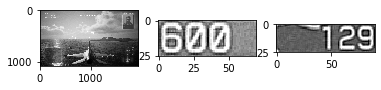

In [165]:
i = cv2.imread('map_full_res.jpg')
i = cv2.cvtColor(i, cv2.COLOR_BGR2GRAY)
i2 = i
plt.subplot(1,3,1)
plt.imshow(i,cmap='gray')
i = i[SPEEDBOX_Y:SPEEDBOX_YH, SPEEDBOX_X:SPEEDBOX_XH]
i = cv2.GaussianBlur(i,(3,3),cv2.BORDER_DEFAULT)
i = cv2.filter2D(i,-1,sharpeningKernel)
print("Speed: "+processOCR(pytesseract.image_to_string(i,lang='eng')))
plt.subplot(1,3,2)
plt.imshow(i,cmap='gray')
i = i2[ALTIBOX_Y:ALTIBOX_YH, ALTIBOX_X:ALTIBOX_XH]
i = cv2.GaussianBlur(i,(3,3),cv2.BORDER_DEFAULT)
i = cv2.filter2D(i,-1,sharpeningKernel)
plt.subplot(1,3,3)
plt.imshow(i,cmap='gray')
print("Altitude: "+processOCR(pytesseract.image_to_string(i,lang='eng')))
plt.show()

In [231]:
f = pd.read_csv(CSV_DATASET_PATH)
f = f.drop("Unnamed: 0", axis=1).dropna()
f

,imgPath,angle,distance,speed,altitude,key_a,key_d,key_1,key_3,key_q,key_e,key_w,key_s
3,dataset/1/11445.jpg,-30.84,161.90,520.0,2575.0,0,0,1,0,0,0,0,0
4,dataset/1/11445.jpg,-15.95,138.32,520.0,2575.0,0,0,1,0,0,0,0,0
5,dataset/1/11445.jpg,33.90,150.60,520.0,2575.0,0,0,1,0,0,0,0,0
214,dataset/D/D1400.jpg,35.35,181.46,593.0,172.0,0,1,0,0,0,0,0,0
215,dataset/D/D1400.jpg,-160.10,61.68,593.0,172.0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
7324,dataset/W/W42.jpg,-5.38,138.61,748.0,454.0,0,0,0,0,0,0,1,0
7325,dataset/W/W42.jpg,-10.69,145.53,748.0,454.0,0,0,0,0,0,0,1,0
7326,dataset/W/W41.jpg,-2.86,140.17,841.0,468.0,0,0,0,0,0,0,1,0
7327,dataset/W/W40.jpg,3.68,140.29,805.0,474.0,0,0,0,0,0,0,1,0


In [34]:
def playGameUsingCV():
    cnt = 0
    controlFlag = False
    while True:
        try:
            k = checkKeys()
            if 'P' in k:
                controlFlag = not controlFlag
                if controlFlag:
                    makeBeep('on')
                else:
                    keyboard.release('e')
                    keyboard.release('a')
                    keyboard.release('d')
                    keyboard.release('q')
                    keyboard.release('s')
                    makeBeep('off')
                    break
            if controlFlag:
                screenshot = getScreenshot(convertToNumpy=True)
                i = screenshot[723:1026,98:401]
                i = cv2.resize(i, (I_WIDTH, I_HEIGHT))
                i = Image.fromarray(i)
                ce, be, cole = ImageEnhance.Contrast(i), ImageEnhance.Brightness(i), ImageEnhance.Color(i)
                i = be.enhance(0.2)
                i = ce.enhance(0.5)
                i = cole.enhance(3.0)
                i = np.asarray(i)
                i = getRedColor(i,BGRinput=True)
                i = rgbToBinary(i)
                cnts = getContours(i)
                cx, cy = getContourCenter(cnts)
                angles, dist = getTargetAngleAndDistance(cx, cy)
                print(angles, dist)
                sortedAngle = angles[0]
                sortedDist = dist[0]
                speed = getSpeed(screenshot)
                altitude = getAltitude(screenshot)
                print(sortedAngle, sortedDist)
                keyboard.release('e')
                keyboard.release('a')
                keyboard.release('d')
                keyboard.release('s')
                keyboard.release('q')
                if sortedAngle <= 0 and sortedAngle > -15:
                    keyboard.press('q')
                    sleep(KEY_PRESS_TIME)
                elif sortedAngle >= -90 and sortedAngle < -17:
                    keyboard.press('a')
                    sleep(KEY_PRESS_TIME)
                elif sortedAngle >= -180 and sortedAngle < -90:
                    keyboard.press('w')
                    keyboard.press('s')
                    keyboard.press('a')
                    sleep(KEY_PRESS_TIME)
                elif sortedAngle >= 0 and sortedAngle < 15:
                    keyboard.press('e')
                    sleep(KEY_PRESS_TIME)
                elif sortedAngle > 17 and sortedAngle < 90:
                    keyboard.press('d')
                    sleep(KEY_PRESS_TIME)
                elif sortedAngle > 90 and sortedAngle < 180:
                    keyboard.press('w')
                    keyboard.press('s')
                    keyboard.press('d')
                    sleep(KEY_PRESS_TIME)
        except ZeroDivisionError:
            pass
        except KeyboardInterrupt:
            keyboard.release('e')
            keyboard.release('a')
            keyboard.release('d')
            keyboard.release('q')
            keyboard.release('s')
            print("KeyboardInterrupt Exception Ocuured")
            break
        except Exception as e:
            keyboard.release('e')
            keyboard.release('a')
            keyboard.release('d')
            keyboard.release('q')
            keyboard.release('s')
            print("Exception Ocuured")
            #raise(e)
            print(e)

In [36]:
playGameUsingCV()

[] []
Exception Ocuured
list index out of range
Exception Ocuured
OpenCV(4.1.2) d:\bld\libopencv_1574456195892\work\modules\imgproc\src\color.simd_helpers.hpp:92: error: (-2:Unspecified error) in function '__cdecl cv::impl::`anonymous-namespace'::CvtHelper<struct cv::impl::`anonymous namespace'::Set<3,4,-1>,struct cv::impl::A0x288afece::Set<3,-1,-1>,struct cv::impl::A0x288afece::Set<0,5,-1>,2>::CvtHelper(const class cv::_InputArray &,const class cv::_OutputArray &,int)'
> Invalid number of channels in input image:
>     'VScn::contains(scn)'
> where
>     'scn' is 1

Exception Ocuured
OpenCV(4.1.2) d:\bld\libopencv_1574456195892\work\modules\imgproc\src\color.simd_helpers.hpp:92: error: (-2:Unspecified error) in function '__cdecl cv::impl::`anonymous-namespace'::CvtHelper<struct cv::impl::`anonymous namespace'::Set<3,4,-1>,struct cv::impl::A0x288afece::Set<3,-1,-1>,struct cv::impl::A0x288afece::Set<0,5,-1>,2>::CvtHelper(const class cv::_InputArray &,const class cv::_OutputArray &,int)'

[] []
Exception Ocuured
list index out of range
[] []
Exception Ocuured
list index out of range
[] []
Exception Ocuured
list index out of range
[-52.23] [140.42]
-52.23 140.42
[-52.56] [139.81]
-52.56 139.81
[46.61, -36.34, -27.54] [151.38, 173.81, 157.89]
46.61 151.38
[51.34, -25.06] [140.87, 153.45]
51.34 140.87
[-50.04, 29.16, -8.02, -15.48, -30.66, -37.06] [144.81, 158.03, 150.47, 153.57, 162.75, 184.2]
-50.04 144.81
[-10.59, -6.43] [141.41, 142.9]
-10.59 141.41
[-5.23, -36.62] [142.59, 184.4]
-5.23 142.59
[-6.43, -36.62] [142.9, 184.4]
-6.43 142.9
[-15.89, -4.83, -36.62] [142.44, 142.51, 184.4]
-15.89 142.44
[-9.33, -1.61] [141.88, 142.06]
-9.33 141.88
[-19.18, -22.76, 15.58, -20.05] [146.11, 155.08, 152.61, 157.54]
-19.18 146.11
[-1.64, 25.31, -0.39, -17.07] [140.06, 163.72, 148.0, 146.45]
-1.64 140.06
[-0.42, 1.23, 26.57, 7.7, 3.48, -15.19] [138.0, 140.03, 165.47, 149.35, 148.27, 145.07]
-0.42 138.0
[7.38, 3.7, 5.75, 4.76] [140.16, 139.29, 139.7, 144.5]
7.38 140.16
[10.99, 11.61

-207.24 76.48
[-232.83, -177.04, -240.45, -175.6, -247.34, -94.85, -93.27, -91.08, -69.57, 36.03, 36.43, 26.31, -35.95, 22.89, 36.06, 18.62, 36.68, 14.69, 36.62, -33.69, -37.79, 15.17] [114.2, 58.08, 111.51, 52.15, 98.62, 106.38, 105.17, 106.02, 108.85, 95.21, 104.4, 99.28, 112.41, 97.69, 113.81, 100.24, 122.2, 106.48, 135.8, 165.86, 174.62, 61.13]
-232.83 114.2
[-244.46, -99.73, -263.42, -190.49, -268.0, 78.69, -87.27, 59.3, 33.41, -29.55, 36.67, -39.34, 11.04] [99.74, 106.53, 26.17, 27.46, 86.05, 15.3, 105.12, 111.65, 112.61, 111.51, 112.2, 171.96, 83.55]
-244.46 99.74
[-54.76, -37.28, -52.82, -50.46, 36.03, 36.36, 36.38, -56.81, 17.76, 25.11, 5.77] [112.65, 84.2, 109.2, 111.52, 108.81, 113.0, 118.0, 127.86, 108.16, 106.02, 89.45]
-54.76 112.65
[-240.79, -245.92, -106.6, -36.03, -54.76, -29.74, -57.95, 36.42, 27.53, -45.78, 6.1, 13.2, -11.83, -32.65] [106.55, 102.96, 108.52, 81.61, 112.65, 80.62, 126.25, 128.0, 106.0, 154.87, 131.75, 83.2, 151.21, 168.66]
-240.79 106.55
[-240.52, -24

-48.62 55.97
[-15.64, 57.63, -6.95, -4.57] [25.96, 84.06, 82.61, 125.4]
-15.64 25.96
[-1.51] [38.01]
-1.51 38.01
[-1.51] [38.01]
-1.51 38.01
[-187.43, -183.32, -170.71, -117.78, -92.15, 88.36, -87.18, 78.69, -68.59, -62.05, -52.31, -50.06, -37.12, -31.61, -18.76, -37.22, -16.02, -13.42, -36.45, 7.0, 17.82] [69.58, 69.12, 55.73, 105.12, 80.06, 35.01, 61.07, 35.69, 54.78, 55.47, 111.21, 112.16, 92.8, 106.85, 111.95, 130.6, 112.36, 112.06, 138.0, 114.86, 58.82]
-187.43 69.58
[-1.51] [38.01]
-1.51 38.01
[-1.51] [38.01]
-1.51 38.01
[-118.86, -115.14, -107.1, -92.15, -92.56, -63.85, -60.03, -1.61, -2.15, -54.56, 0.69, -36.36, -33.69, -29.55, -19.98, 12.8, -36.32, -35.18, -7.01, -35.75, -6.48, -11.7, 43.21] [111.89, 108.26, 54.41, 80.06, 67.07, 122.54, 128.13, 71.03, 80.06, 136.24, 83.01, 113.0, 111.77, 111.51, 105.34, 112.81, 145.21, 149.26, 122.92, 154.03, 132.85, 142.97, 45.28]
-118.86 111.89
[-188.28, -107.1, -87.43, -71.88, -68.59, -73.64, -64.27, -33.69, -18.6, -10.18, -36.35, -6.48, 44

-97.13 24.19
[-73.91, -71.06, -69.44, -50.53, -49.49, -47.64, -34.36, 36.62, 21.4] [108.24, 107.84, 42.72, 132.14, 135.47, 138.03, 118.71, 184.4, 158.96]
-73.91 108.24
[-74.79, -75.47, -72.4, -70.73, -72.9, -68.29, -64.8, -51.55, -50.47, -48.58, -34.91, 36.62, 19.36] [106.74, 111.57, 109.11, 109.11, 40.8, 116.25, 112.73, 130.25, 133.54, 136.03, 117.07, 184.4, 156.87]
-74.79 106.74
[-190.41, -66.37, -58.79, -56.31, -24.66] [49.82, 34.93, 121.59, 122.59, 107.84]
-190.41 49.82
[-184.97, -74.05, -31.33, -64.75, -65.56, -23.96, -47.64] [46.17, 58.24, 26.93, 58.6, 36.25, 108.34, 138.03]
-184.97 46.17
[-176.42, -64.75, -64.18, -14.44, -37.64] [48.09, 58.6, 34.44, 104.29, 149.01]
-176.42 48.09
[-167.35, -65.64, -54.46, -4.44, -27.27] [50.22, 58.18, 34.41, 103.31, 146.25]
-167.35 50.22
[-53.47, -1.72, -41.69, 35.31, -23.51] [33.6, 100.04, 159.36, 176.47, 142.86]
-53.47 33.6
[-54.87, 4.09, -39.67, -22.4] [33.02, 98.25, 159.79, 141.69]
-54.87 33.02
[-54.25, 11.31, -27.94] [30.81, 91.78, 149.41]
-

-236.55 130.63
[-236.55, -148.2, -172.87, -96.2, -111.31, -95.97, -6.58, -44.64, -5.91, 37.6, -16.19, -57.67, -19.16, -36.97, -29.55, 1.91, -2.57, 46.65, 38.16, -44.24, 1.91, -4.65, 1.72, 37.9, -6.03] [130.63, 58.83, 24.19, 92.54, 107.34, 86.47, 78.52, 112.43, 87.46, 109.81, 96.84, 129.0, 100.57, 111.4, 111.51, 90.05, 89.09, 147.14, 142.44, 159.11, 120.07, 123.41, 133.06, 177.43, 142.79]
-236.55 130.63
[-132.74, -186.84, -160.56, -115.14, -173.29, -2.6, 37.12, 47.55, 37.57, 44.27, 2.15, 36.76, -35.99, -59.19, 38.33, -32.28, 1.89, -2.52, -30.26, 39.01, -26.57, -16.1, -46.32, 35.77, 46.09, 35.58, -2.17, 36.87, 3.68] [107.56, 25.18, 54.08, 108.26, 17.12, 66.07, 92.8, 111.13, 98.41, 111.73, 80.06, 103.6, 103.81, 126.91, 109.64, 112.36, 91.05, 91.09, 111.14, 128.69, 111.8, 100.96, 153.48, 145.43, 148.52, 151.24, 132.09, 175.0, 140.29]
-132.74 107.56
[-124.95] [101.26]
-124.95 101.26
[-185.27, -129.19] [65.28, 83.87]
-185.27 65.28
[-210.1, -213.27, -209.36, -122.11, -126.33] [79.76, 76.55, 7

-199.29 63.57
[-267.44, -266.5, -266.42, 86.42, -33.69, -49.4, -7.59, -37.87, -29.05, -48.62, 39.94, -19.23, 26.03, 18.82, -25.51, -37.79, 33.11, -34.99, 61.59, 36.45, 33.69, -33.69, 36.38, -36.06, 36.63, 39.42, 37.94, -57.38] [67.07, 49.09, 32.06, 48.09, 14.42, 18.44, 15.13, 34.21, 30.89, 55.97, 56.08, 45.54, 47.85, 46.49, 48.75, 62.01, 54.92, 48.83, 111.41, 109.4, 111.77, 111.77, 118.0, 113.81, 145.8, 152.75, 149.63, 29.68]
-267.44 67.07
[-117.03, -118.07, -107.42, -96.58, -265.91, -266.42, -95.44, -94.76, -84.47, -80.13, 49.03, 47.17, 19.65, 38.37, -17.35, 62.74, 36.87, -14.28, 59.74, 55.6, 49.73, 6.01, 35.99, -44.31, 37.38, 32.7, 16.42, 12.91, -36.36, 30.0, 36.87, -44.13, 14.97, 17.26, -1.7, -37.14, 13.78, 37.69, 7.7, -38.27, 36.63, 47.45, -17.62, -91.71] [55.01, 51.0, 53.45, 26.17, 56.14, 32.06, 21.1, 36.12, 31.14, 23.35, 50.33, 55.9, 44.6, 61.22, 50.29, 111.36, 65.0, 56.75, 111.14, 111.5, 111.4, 38.21, 103.81, 117.39, 112.0, 112.9, 99.04, 98.49, 113.0, 112.0, 125.0, 139.32, 104.5

-251.41 116.06
[-191.31, -197.88, -133.03, -141.01, -3.18, 43.06, -74.74, 37.65, -31.79, 35.78, 37.12, -4.54, 36.03, -2.23, -55.95, 9.57, 6.34, 57.8, 45.27, 36.32, 42.51, 40.9, 37.71, 35.05, 30.21] [40.79, 65.15, 41.04, 27.02, 36.06, 83.49, 114.02, 88.41, 83.53, 83.82, 92.8, 63.2, 95.21, 77.06, 133.96, 84.17, 54.33, 127.62, 152.03, 145.21, 162.79, 168.01, 178.22, 175.89, 168.94]
-191.31 40.79
[-133.63, -132.83, -230.91, -128.66, -92.15, 35.1, 9.16, -23.43, 62.02, 2.73, -2.6, 49.11, -40.89, 38.01, -76.79, 57.95, -7.41, 6.84, -42.06, 7.07] [88.41, 55.9, 103.08, 38.42, 80.06, 45.22, 31.4, 32.7, 108.71, 63.07, 66.07, 108.47, 108.47, 110.42, 100.66, 126.25, 100.84, 125.9, 165.68, 129.99]
-133.63 88.41
[-178.43, -235.7, -193.11, -131.24, -243.85, -133.57, -126.25, -126.87, -91.68, -91.43, -91.32, -86.53, -76.5, -84.34, -30.96, -65.7, -38.45, -30.96, -27.12, 61.7, 20.85, -16.11, -56.45, 2.15, -1.41, -62.8, 36.03, 32.98, -3.04, 29.3, 37.16, -48.27, -3.27, 38.02, 8.2, 2.78, -1.49, 17.04] [73.03

90.0 3.0
[-189.46, 32.2, 19.78, 16.43, 17.82, 36.62, 14.4] [6.08, 95.72, 147.72, 144.92, 147.05, 184.4, 152.8]
-189.46 6.08
[-162.65, 45.0, 38.16] [16.76, 89.1, 178.04]
-162.65 16.76
[-160.71, 45.95] [21.19, 84.86]
-160.71 21.19
[-152.53, 49.0, 46.75, 40.45, 36.62, 24.03, -7.7, -34.84] [28.18, 141.77, 138.66, 169.53, 184.4, 162.05, 149.35, 180.31]
-152.53 28.18
[-150.75, 51.01, 49.62, 47.39, 47.83, 38.16, 36.62, 26.87, -3.87, -34.94] [28.65, 135.09, 140.46, 135.88, 143.01, 178.04, 184.4, 165.92, 148.34, 178.1]
-150.75 28.65
[-143.13, 81.79, 79.99, 70.64, 46.37, 44.17, 46.88, 36.62, 31.59] [35.0, 98.01, 103.58, 78.43, 147.83, 146.39, 150.7, 184.4, 173.74]
-143.13 35.0
[-250.91, -115.91] [110.05, 38.91]
-250.91 110.05
[-239.36, -243.21, -113.39, -255.58] [119.71, 115.38, 40.31, 72.28]
-239.36 119.71
[-237.09, -91.76, -86.63, 36.62] [121.49, 65.03, 51.09, 184.4]
-237.09 121.49
[-236.43, -84.05, 36.62] [132.02, 48.26, 184.4]
-236.43 132.02
[-86.1] [44.1]
-86.1 44.1
[-86.35] [47.1]
-86.35 4

-119.58 127.63
[-245.56, -180.0, -86.89, 19.98, -190.89, 34.59, -4.09, 34.88, 36.61, 35.94, -59.12, -3.43, 57.26, -2.64, 37.28, 39.64, -52.03, 49.01, -36.03, 31.33, -46.19, -38.01, -40.45, 26.57, -36.13, 39.53, 37.92, -39.53, 37.57, 36.62, -6.55, -8.53, 7.52] [108.75, 7.0, 92.14, 23.41, 52.95, 35.23, 28.07, 40.22, 43.6, 49.41, 113.02, 50.09, 116.5, 65.07, 84.2, 90.91, 104.02, 111.29, 95.21, 107.7, 135.79, 110.42, 124.84, 111.8, 123.81, 133.54, 109.02, 133.54, 131.21, 135.8, 122.8, 141.57, 106.92]
-245.56 108.75
[-142.13, 28.99] [57.01, 169.2]
-142.13 57.01
[] []
Exception Ocuured
list index out of range
[] []
Exception Ocuured
list index out of range
[-143.33, 36.62] [58.6, 184.4]
-143.33 58.6
[-141.95] [58.41]
-141.95 58.41
[-149.49] [65.0]
-149.49 65.0
[-141.48, -119.74, -126.63, -121.48] [62.63, 64.5, 48.6, 57.45]
-141.48 62.63
[-134.36] [62.94]
-134.36 62.94
[-127.57] [65.6]
-127.57 65.6
[-111.1] [61.1]
-111.1 61.1
[-109.33] [60.41]
-109.33 60.41
[-236.43, -81.42, 18.32, -27.79] [1

-1.51 38.01
[-1.51] [38.01]
-1.51 38.01
[-1.51] [38.01]
-1.51 38.01
[-1.51] [38.01]
-1.51 38.01
[-239.68, -237.3, -239.56, -122.64, -121.64, -180.0, -256.09, -92.77, -268.57, -266.88, -93.37, -84.81, -85.49, 84.9, -84.61, -35.54, 35.31, 6.34, -30.65, -24.44, 35.84, -32.57, -49.29, 47.17, -26.03, -34.99, 24.62, 37.06, -37.06, 34.29, 36.87, -37.57, 20.67, -59.3, -14.26, -19.59, -37.28, -50.06, -5.6, 52.13, 36.41, -1.45, 36.43, -1.32, 30.0, 36.68, -34.14, 41.7, 37.12, 7.7, 36.38, -36.35, 20.14] [122.8, 112.9, 112.51, 105.69, 101.02, 42.0, 108.17, 62.07, 80.02, 55.08, 51.09, 33.14, 38.12, 56.22, 53.24, 25.81, 29.41, 27.17, 31.38, 36.25, 44.41, 42.72, 56.73, 55.9, 47.85, 48.83, 52.8, 61.4, 61.4, 53.25, 65.0, 65.6, 56.65, 111.65, 60.88, 62.63, 84.2, 112.16, 51.24, 125.42, 99.4, 79.03, 104.4, 87.02, 112.0, 122.2, 105.12, 147.32, 139.2, 112.01, 141.61, 155.21, 63.91]
-239.68 122.8
[-184.18, -107.97, -71.57, 36.87, 34.7, -4.09, -34.7, 38.29, 35.31, 35.91, -44.12, -24.44, 25.51, 18.82, -23.63, -

-206.88 81.84
[-115.1, -241.58, -225.0, -200.81, -165.32, -128.4, -165.96, -267.75, 78.27, -260.34, 42.83, 39.29, 34.25, 32.91, -79.79, 36.87, -8.82, -4.76, 34.93, 36.87, -2.68, 36.33, 7.03, 67.92, -36.06, -33.69, -37.12, 46.61, 0.62, 40.67, 39.17, -0.83, -30.05, 37.51, 1.19, -17.02, -38.44] [122.58, 96.65, 53.74, 53.49, 43.42, 67.62, 4.12, 51.04, 54.13, 95.35, 55.9, 56.85, 56.86, 60.75, 112.79, 70.0, 58.69, 48.17, 76.84, 80.0, 64.07, 84.4, 73.55, 114.39, 113.81, 111.77, 139.2, 151.38, 92.01, 168.77, 174.14, 138.01, 161.74, 179.01, 145.03, 153.73, 160.86]
-115.1 122.58
[-159.72, -189.04, -172.23, -136.19, -114.33, -251.4, -99.37, -100.71, -94.4, -92.69, -105.17, -88.06, -88.21, -86.19, -89.48, 59.3, 49.34, -68.38, 36.03, 35.94, 1.35, -1.35, 36.42, 28.95, 13.54, 37.69, -7.7, 36.32, -36.27, 60.72, -41.72, 37.32, 31.54, -10.41, 3.06, -21.4] [49.04, 44.55, 44.41, 67.9, 80.11, 106.57, 104.39, 112.97, 39.12, 85.09, 61.13, 59.03, 64.03, 45.1, 111.0, 111.65, 112.04, 119.4, 95.21, 98.81, 85.02,

-183.81 30.07
[-176.35, -183.01, -33.69, 33.69, 12.09, -36.87, -43.03, 37.3, -1.91, 60.7, 2.96, -2.01, -1.74, -1.59, -1.47, -42.45, 36.43, 33.69, -32.98, 36.97, 30.0, -30.0, 36.68, 27.02, 18.92, 14.69, -12.8, 37.12, 36.32, -9.69, -17.74] [47.1, 38.05, 7.21, 14.42, 14.32, 15.0, 20.52, 26.4, 30.02, 112.38, 58.08, 57.04, 66.03, 72.03, 78.03, 111.13, 104.4, 111.77, 112.06, 111.4, 112.0, 112.0, 122.2, 112.25, 111.0, 106.48, 112.81, 139.2, 145.21, 124.78, 26.25]
-176.35 47.1
[-176.99, -268.47, -87.65, -38.66, -34.22, 0.0, -2.01, -1.82, -53.03, 52.31, 49.73, -50.06, -1.59, 34.18, -1.35, 0.0, 36.59, 31.89, 0.99, -2.96, 2.49, 0.0, -96.12] [38.05, 75.03, 73.06, 19.21, 30.23, 28.0, 57.04, 63.03, 111.4, 111.21, 111.4, 112.16, 72.03, 97.91, 85.02, 94.0, 120.8, 106.0, 116.02, 116.16, 138.13, 147.0, 28.16]
-176.99 38.05
[-209.32, -126.68, -223.39, -164.68, -183.27, -175.91, -183.43, -175.6, -176.19, -175.6, -92.77, -93.01, 83.42, -79.22, -81.57, -33.69, 36.87, -35.91, -37.41, -1.91, 1.82, 1.74, -1.76

-177.88 54.04
[-176.35, -183.73, -184.18, -177.14, -92.12, 81.57, 12.09, -33.69, -43.03, 35.75, 0.0, 3.5, -2.34, -37.57, 3.01, -1.97, 58.16, 49.73, 2.35, -1.57, 36.51, 36.41, -0.66, 38.01, 32.55, 36.38, 19.16, 30.0, 36.68, 0.0, 22.7, 37.12, -46.61, 36.55, 36.03, -64.98, -14.4, -34.76] [47.1, 46.1, 41.11, 40.05, 27.02, 27.29, 14.32, 14.42, 20.52, 30.81, 27.0, 49.09, 49.04, 65.6, 57.08, 58.03, 111.83, 111.4, 73.06, 73.03, 95.8, 99.4, 87.01, 110.42, 111.52, 118.0, 100.57, 112.0, 122.2, 98.0, 106.23, 139.2, 151.38, 144.4, 149.62, 33.11, 152.8, 178.92]
-176.35 47.1
[-222.36, -120.89, -165.75, -120.65, -177.14, -182.6, -176.19, -267.68, -98.13, 87.68, 84.64, 83.66, -81.47, 36.87, -34.22, -35.91, -67.83, -15.26, 35.84, -8.82, 2.64, 52.31, 34.73, 7.7, -35.17, -26.72, -31.33, -17.97, -22.54, -33.96] [92.02, 130.51, 65.0, 94.15, 40.05, 66.07, 30.07, 74.06, 21.21, 74.06, 32.14, 27.17, 20.22, 10.0, 30.23, 35.81, 87.46, 34.21, 44.41, 58.69, 65.07, 111.21, 107.07, 112.01, 161.47, 164.58, 53.85, 155.

-193.54 55.54
[-180.0, -79.99] [38.0, 51.79]
-180.0 38.0
[-176.01, -83.42] [43.1, 52.35]
-176.01 43.1
[-170.96] [44.55]
-170.96 44.55
[-174.17, -99.78] [49.25, 58.86]
-174.17 49.25
[-166.76, -105.57, -92.77] [52.39, 63.32, 62.07]
-166.76 52.39
[-236.43, -155.73, -86.48] [132.02, 55.95, 65.12]
-236.43 132.02
[-147.45, -91.74, -75.76, -36.62] [55.76, 66.03, 69.12, 184.4]
-147.45 55.76
[-1.51] [38.01]
-1.51 38.01
[-1.51] [38.01]
-1.51 38.01
[-235.73, -164.2, -240.9, -184.18, -176.73, -66.37, 35.54, 36.87, -8.13, -34.51, 36.03, 37.18, -35.91, 37.15, -37.41, 37.12, 36.19, 0.0, 2.05, 2.91, -3.01, -1.82, 1.74, -1.57, 51.56, -1.47, 36.87, -1.3, 1.87, -1.23, 36.96, 30.0, -32.77, -25.88, 18.76, -16.02, 36.62, 7.7, 39.42, 8.93, -62.1] [110.11, 55.08, 111.02, 41.11, 35.06, 17.46, 8.6, 15.0, 14.14, 19.42, 27.2, 36.4, 35.81, 41.4, 42.8, 46.4, 50.8, 31.0, 56.04, 59.08, 57.08, 63.03, 66.03, 73.03, 123.85, 78.03, 100.0, 88.02, 92.05, 93.02, 121.4, 112.0, 103.46, 112.26, 111.95, 112.36, 135.8, 112.01, 1

63.43 22.36
[75.26, 36.62] [19.65, 184.4]
75.26 19.65
[-234.78, 43.03, 36.62] [20.81, 20.52, 184.4]
-234.78 20.81
[-226.85, 25.2, 36.62] [21.93, 18.79, 184.4]
-226.85 21.93
[-223.36, 18.43] [24.76, 12.65]
-223.36 24.76
[-236.43, -18.43] [132.02, 3.16]
-236.43 132.02
[-236.43, -18.43] [132.02, 3.16]
-236.43 132.02
[-135.0] [7.07]
-135.0 7.07
[-148.39] [15.26]
-148.39 15.26
[-148.57] [21.1]
-148.57 21.1
[-215.22, -171.87] [41.62, 35.36]
-215.22 41.62
[-140.71] [42.64]
-140.71 42.64
[-185.71, -153.95] [40.2, 50.09]
-185.71 40.2
[-137.82] [43.19]
-137.82 43.19
[-131.63, 36.62] [48.17, 184.4]
-131.63 48.17
[-130.82] [58.14]
-130.82 58.14
[-236.43, -140.31] [132.02, 61.07]
-236.43 132.02
[-127.87] [68.41]
-127.87 68.41
[-124.59] [70.46]
-124.59 70.46
[-236.43, -111.64] [132.02, 67.78]
-236.43 132.02
[-122.09, 36.62] [69.64, 184.4]
-122.09 69.64
[-113.53] [67.62]
-113.53 67.62
[-102.62] [68.66]
-102.62 68.66
[-236.43, -101.14] [132.02, 67.27]
-236.43 132.02
[-80.68] [67.9]
-80.68 67.9
[-70.75

-152.47 80.06
[-158.63, -177.95, -74.42, 3.09, 3.9, 3.58, -3.12, -1.97, -14.5, -54.56, 40.99, 57.21, -42.55, 9.27, 37.76, 22.07] [74.09, 56.04, 107.97, 37.05, 44.1, 48.09, 55.08, 58.03, 59.91, 136.24, 111.29, 123.71, 82.81, 148.95, 168.22, 159.7]
-158.63 74.09
[-176.35, -205.11, -8.28, -70.92, 52.31, 49.01, 36.41, 36.43, -36.71, -54.22, 39.47, -26.31, 57.7, -33.27, -14.44, -22.91, 45.53, 38.38, 15.48] [47.1, 70.68, 55.58, 113.22, 111.21, 111.29, 99.4, 104.4, 73.6, 136.82, 110.11, 99.28, 125.4, 114.83, 104.29, 105.31, 152.74, 159.46, 153.57]
-176.35 47.1
[-228.99, -87.3, -84.51, -85.88, 2.86, -65.77, -10.62, 2.29, -3.43, -2.08, -59.12, -66.67, 36.41, 32.55, 37.48, -34.29, 55.81, -32.44, -34.3, -36.03, 8.2, -37.12, -42.65, 38.02] [91.44, 106.12, 104.48, 111.29, 40.05, 109.66, 48.84, 50.04, 50.09, 55.04, 113.02, 118.7, 99.4, 111.52, 113.41, 79.88, 128.14, 126.78, 129.53, 136.01, 112.15, 139.2, 154.99, 168.83]
-228.99 91.44
[-232.08, -92.32, -86.91, 6.71, -25.2, 37.08, 39.54, -77.41, 58.09

-139.21 96.43
[-10.92, -44.49, -30.96, 36.72, -32.22] [116.1, 159.81, 11.66, 152.2, 172.57]
-10.92 116.1
[-10.92, -43.99, -30.96, 36.72, -32.22] [116.1, 161.25, 11.66, 152.2, 172.57]
-10.92 116.1
[-10.92, -44.24, -30.96, 36.72, -32.22] [116.1, 160.53, 11.66, 152.2, 172.57]
-10.92 116.1
[-11.41, -30.96, -44.24, 36.72, -32.22] [116.3, 11.66, 160.53, 152.2, 172.57]
-11.41 116.3
[-10.92, -43.99, -30.96, 36.72, -32.22] [116.1, 159.83, 11.66, 152.2, 172.57]
-10.92 116.1
[-10.92, -44.49, -30.96, 36.72, -32.22] [116.1, 159.81, 11.66, 152.2, 172.57]
-10.92 116.1
